# Twitch Gini Coefficients

Here's the notebook for calculating the Gini coefficient for Twitch incomes distributed amongst Twitch partners. The data for this was obtained via a data leak of Twitch's servers. The data are being scrubbed from the web, but feel free to contact me for the file

In [1]:
import pandas as pd
import numpy as np 
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.integrate import quad
import scipy.optimize as opt

In [2]:
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
sns.set(font='DejaVu Sans',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

In [3]:
data = pd.read_csv("TwitchEarnings.txt", header=0, delimiter=' ')
data.head()

,Rank,Username,UserID,GrossEarning
0,1,CriticalRole,229729353,9626712.16
1,2,xQcOW,71092938,8454427.17
2,3,summit1g,26490481,5847541.17
3,4,Tfue,60056333,5295582.44
4,5,NICKMERCS,15564828,5096642.12


The data leak provides the top 10,000 twitch streamers according to gross earnings (which includes money from subscriptions, bits, and advertisement revenue). According to the [Twitch FAQ](https://www.twitch.tv/p/en/partners/faq/), however, there are about 27,000 twitch streamers. This means we'll have to approximate the remaining revenue for the 17,000 not found in the leak. Let's dive into the data to see what functional forms we need

In [4]:
num_partners = 27000

Text(0.5, 1.0, 'Power Law')

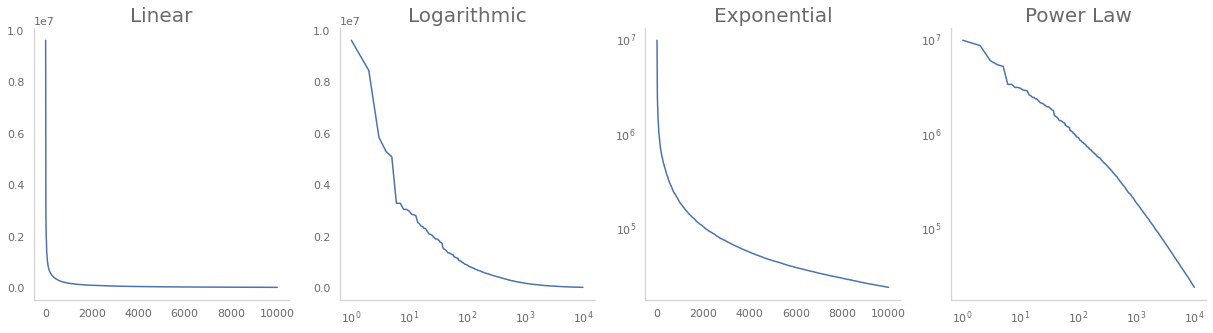

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(21, 5))
axes[0].plot(data['Rank'], data['GrossEarning'])
axes[0].set_title("Linear")

axes[1].plot(data['Rank'], data['GrossEarning'])
axes[1].set_xscale('log')
axes[1].set_title("Logarithmic")

axes[2].plot(data['Rank'], data['GrossEarning'])
axes[2].set_yscale('log')
axes[2].set_title("Exponential")

axes[3].plot(data['Rank'], data['GrossEarning'])


axes[3].set_xscale('log')
axes[3].set_yscale('log')
axes[3].set_title("Power Law")

The distribution of income thus most closely resembles a power law (although not perfectly). We'll thus approximate function with $f(x) = A * e^{-a  \ln (x)^b}$ and solve for the three parameters, $A, a, b$

In [6]:
def parametric_fit(rank, a=0.25, b=1.45, logA=np.log(max(data['GrossEarning']))):
    A = np.exp(logA)
    return A * np.exp(- a * np.log(rank)**b)

def Loss(param_vector):
    wrapper = lambda x: parametric_fit(x.to_numpy(), *param_vector)
    N = len(data['Rank'])
    RMSLE = np.sqrt(1/N * np.sum((np.log(data['GrossEarning'] + 1) - np.log(wrapper(data['Rank']) + 1))**2))
    return np.sum(RMSLE)

In [7]:
init_params = np.array([0.25, 1.68, np.log(max(data['GrossEarning']))])
optimal_params = opt.minimize(Loss, x0=init_params, method='Nelder-Mead')
optimal_params

 final_simplex: (array([[ 0.14057675,  1.6461845 , 15.50246926],
       [ 0.14056949,  1.64620489, 15.50243223],
       [ 0.14057401,  1.64619331, 15.50245907],
       [ 0.14058887,  1.64615404, 15.5025668 ]]), array([0.01376258, 0.01376258, 0.01376258, 0.01376258]))
           fun: 0.013762579389462943
       message: 'Optimization terminated successfully.'
          nfev: 515
           nit: 304
        status: 0
       success: True
             x: array([ 0.14057675,  1.6461845 , 15.50246926])

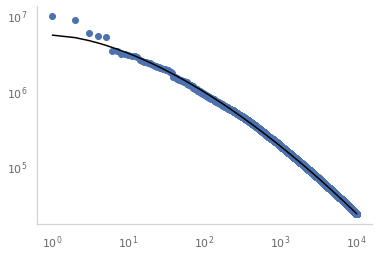

In [8]:
x = np.linspace(1, len(data['Rank']), len(data['Rank']))

plt.scatter(data['Rank'], data['GrossEarning'])
plt.plot(x, parametric_fit(x, *optimal_params.x), color='black')
plt.xscale('log')
plt.yscale('log')

It looks like our guess at the functional form worked out! With the optimal parameters found, we can extrapolate the earned income out to the total number of partnered Twitch streamers. The total amount of money Twitch paid out is then the sum of this function over all of these people

In [9]:
ranks = np.linspace(1, num_partners + 1, num_partners)
fractional_rank = (np.cumsum(ranks))/(np.sum(ranks))

Total_Twitch_Payout = np.sum(parametric_fit(ranks, *optimal_params.x))
Total_Twitch_Payout

1225421155.4522352

Twitch has thus paid out over a billion dollars over the 26 months this data leak covers! We now have enough information to calculate the Lorenz curve and obtain the Gini coefficient

In [10]:
fraction_of_income = np.cumsum(parametric_fit(ranks, *optimal_params.x))/ Total_Twitch_Payout

In [11]:
Lorenz = interp1d(fraction_of_income, fractional_rank, fill_value='extrapolate')

Text(0, 0.5, '% of Twitch income')

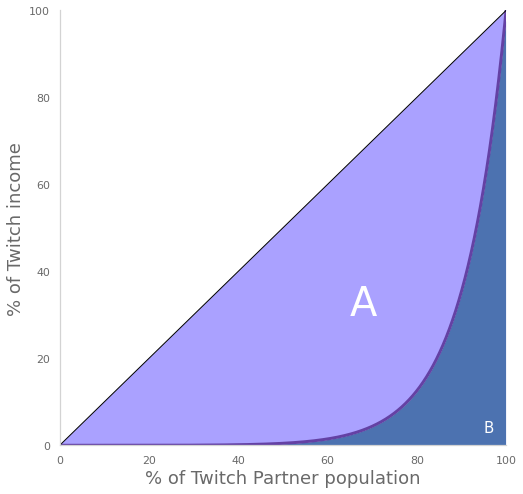

In [12]:
x = np.linspace(0, 1., 10000)
plt.figure(figsize=(8, 8))
plt.plot(100* x, 100 *  Lorenz(x), linewidth=3, color="#6441A4")
plt.plot([0, 100], [0, 100], color='black', linewidth=1)

plt.fill_between(100* x, 100* x, color="#AAA1FF")
plt.fill_between(100* x, 100 *  Lorenz(x))

plt.xlim(0, 100)
plt.ylim(0, 100)

plt.text(65, 30, "A", color='white', fontsize=40)
plt.text(95., 3, "B", color='white', fontsize=15)

plt.xlabel("% of Twitch Partner population")
plt.ylabel("% of Twitch income")

In [13]:
AplusB = 0.5  # area of unit square under diagonal
B = quad(Lorenz, 0., 1)[0]
A = AplusB - B
Gini = A/(A + B)
Gini

0.8084053482042313

The Gini coefficient for Twitch partners is 0.808!

In [14]:
pct = 0.1
(1 - Lorenz(1 - pct/100))

0.010409677770780501

The top 0.1% make 1% of all Twitch income!